# EE4414 Lab Part1_Image_Classification

## Acknowledgment

This lab experiment is modified based on the Pytorch official tutorial.

You can check the Pytorch official tutorial at https://pytorch.org/tutorials/



## 1. Training a classifier

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

For this part, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

We will do the following steps in order:

1) Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
   
2) Define a Convolutional Neural Network

3) Define a loss function

4) Train the network on the training data

5) Test the network on the test data

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np


### 1.1 Loading and normalizing CIFAR10


Using ``torchvision``, it is easy to load CIFAR10.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified



### 1.2 Visualizing the training images


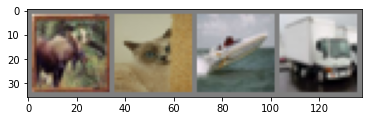

 deer   cat  ship truck


In [4]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 1.3 Getting samples from dataloader

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
np.shape(images[0])

torch.Size([3, 32, 32])

### 1.4 Defining a Convolutional Neural Network



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 1.5 Printing the network structure

In [7]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 1.6 Using Torchsummary to visualize shape of the feature maps in each layer

In [8]:
from torchsummary import summary
summary(net, input_size=(3, 32, 32)) # Here the input size is channel x width x height

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
         MaxPool2d-2            [-1, 6, 16, 16]               0
            Conv2d-3           [-1, 16, 16, 16]             880
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Linear-5                  [-1, 120]         123,000
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 135,062
Trainable params: 135,062
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.52
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


### 1.7 Defining loss function and optimizer

The loss function here is defined as a Classification Cross-Entropy loss and SGD with momentum.



In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 1.8 Training the network

We loop over our data iterator, and feed the inputs to the
network and optimize the parameters.



In [10]:
t1 = time.time()
loss_list = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            loss_list.append(running_loss/1000)
            running_loss = 0.0

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

[1,  1000] loss: 2.261
[1,  2000] loss: 1.980
[1,  3000] loss: 1.821
[1,  4000] loss: 1.719
[1,  5000] loss: 1.613
[1,  6000] loss: 1.570
[1,  7000] loss: 1.495
[1,  8000] loss: 1.488
[1,  9000] loss: 1.423
[1, 10000] loss: 1.399
[1, 11000] loss: 1.377
[1, 12000] loss: 1.368
[2,  1000] loss: 1.255
[2,  2000] loss: 1.263
[2,  3000] loss: 1.242
[2,  4000] loss: 1.241
[2,  5000] loss: 1.208
[2,  6000] loss: 1.224
[2,  7000] loss: 1.184
[2,  8000] loss: 1.182
[2,  9000] loss: 1.165
[2, 10000] loss: 1.156
[2, 11000] loss: 1.162
[2, 12000] loss: 1.155
Finished Training
Training time:144.7705216407776


## Exercise 1.1 Plotting of loss function

In the previous cell, we have saved the loss function at different iterations in the loss_list.

Now, plot the loss function versus the iteration number using matplotlib.

You can find the tutorial of plotting figure using matplotlib here:
https://matplotlib.org/3.3.3/gallery/lines_bars_and_markers/simple_plot.html#sphx-glr-gallery-lines-bars-and-markers-simple-plot-py

### E1.1.2 Plotting the loss function vs interation number (To do)

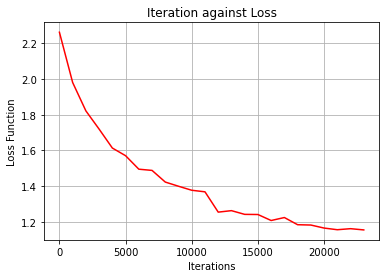

In [47]:
# Data for plotting
#t = np.arange(0.0, 2.0, 0.01)
#s = 1 + np.sin(2 * np.pi * t)

Iterations = (np.arange(0,24000,1000))

fig, ax = plt.subplots()
ax.plot(Iterations,loss_list,'r')

ax.set(ylabel='Loss Function',xlabel = 'Iterations',
       title='Iteration against Loss')

ax.grid()

plt.show()

### 1.9 Saving the trained model

In [13]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See https://pytorch.org/docs/stable/notes/serialization.html
for more details on saving PyTorch models.

### 1.10 Evaluating network performance on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnd anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.



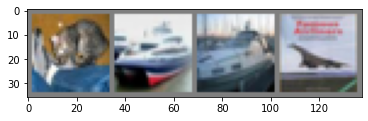

GroundTruth:    cat  ship  ship plane


In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 1.11 Loading the saved model 
Note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so



In [15]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 1.12 Predicting using the loaded model



In [16]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.

### 1.13 Getting the index of the highest energy



In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


## Exercise 1.2 Evaluating network performance 

In this section, we are going to evaluate the average accuracy for the whole test dataset and find out which classes performed well, and the classes that did not perform well.

Finish the code and calculate the accuracy for each class.


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 59 %
Accuracy of plane : 58 %
Accuracy of   car : 65 %
Accuracy of  bird : 44 %
Accuracy of   cat : 48 %
Accuracy of  deer : 65 %
Accuracy of   dog : 55 %
Accuracy of  frog : 45 %
Accuracy of horse : 59 %
Accuracy of  ship : 79 %
Accuracy of truck : 69 %


## Exercise 1.3 Study of different optimizers

In this exercise, you will learn to train the network using a different optimizer.

In the previous section, we used Stochastic Gradient Descent (SGD). You will use Adam optimizer in this exercise and compare the training process for these two optimizers.

### E1.3.1 Re-initializing the network

In [19]:
net = Net()

### E1.3.2 Defining the Adam optimizer (To do)

You can find the details of Pytorch Adam optimizer here: https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam

Use default parameters: lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False.

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# To do
# optimizer = complete this part

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

### E1.3.3 Training the network with Adam optimizer

In [21]:
t1 = time.time()
loss_list_adam = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            loss_list_adam.append(running_loss/1000)
            running_loss = 0.0

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

[1,  1000] loss: 1.981
[1,  2000] loss: 1.637
[1,  3000] loss: 1.511
[1,  4000] loss: 1.466
[1,  5000] loss: 1.402
[1,  6000] loss: 1.389
[1,  7000] loss: 1.319
[1,  8000] loss: 1.313
[1,  9000] loss: 1.271
[1, 10000] loss: 1.272
[1, 11000] loss: 1.242
[1, 12000] loss: 1.234
[2,  1000] loss: 1.137
[2,  2000] loss: 1.110
[2,  3000] loss: 1.139
[2,  4000] loss: 1.121
[2,  5000] loss: 1.122
[2,  6000] loss: 1.127
[2,  7000] loss: 1.113
[2,  8000] loss: 1.112
[2,  9000] loss: 1.141
[2, 10000] loss: 1.089
[2, 11000] loss: 1.088
[2, 12000] loss: 1.089
Finished Training
Training time:221.5872905254364


### E1.3.5 Plotting the loss graphs for both SGD and Adam optimizers (To do)

Note: Use red color for SGD and blue color for Adam when plotting the graphs.

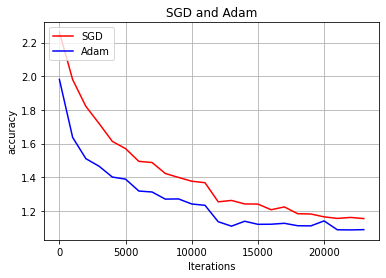

In [45]:
# To do
# Plot the training loss curve

plt.plot(Iterations,loss_list,'r')
plt.plot(Iterations,loss_list_adam,'b')
plt.grid()
plt.title('SGD and Adam')
plt.ylabel('accuracy')
plt.xlabel('Iterations')
plt.legend(['SGD', 'Adam'], loc='upper left')
plt.show()

## Exercise 1.4 Study of different learning rates

In this exercise, you will learn to train the network using a different learning rate.
We will use SGD in this exercise.
The learning rate for the previous experiments is 0.001, we will use 0.01 in this new experiment.

### E1.4.1 Re-initializing the network.

In [23]:
net = Net()

### E1.4.2 Changing the learning rate for SGD optimizer (To do)

In [24]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# To do
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


### E1.4.3 Training the network with larger learning rate

In [25]:
t1 = time.time()
loss_list_larger_lr = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            loss_list_larger_lr.append(running_loss/1000)
            running_loss = 0.0

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

[1,  1000] loss: 2.104
[1,  2000] loss: 1.948
[1,  3000] loss: 1.868
[1,  4000] loss: 1.835
[1,  5000] loss: 1.810
[1,  6000] loss: 1.818
[1,  7000] loss: 1.803
[1,  8000] loss: 1.803
[1,  9000] loss: 1.766
[1, 10000] loss: 1.821
[1, 11000] loss: 1.787
[1, 12000] loss: 1.818
[2,  1000] loss: 1.812
[2,  2000] loss: 1.801
[2,  3000] loss: 1.807
[2,  4000] loss: 1.802
[2,  5000] loss: 1.816
[2,  6000] loss: 1.767
[2,  7000] loss: 1.807
[2,  8000] loss: 1.797
[2,  9000] loss: 1.780
[2, 10000] loss: 1.815
[2, 11000] loss: 1.808
[2, 12000] loss: 1.789
Finished Training
Training time:143.5406186580658


### E1.4.4 Plotting the loss curves for both learning rates (To do)

In the previous section, we have saved the loss value of different iterations in the loss_list for the 0.001 learning rate with SGD optimizer.

Now, plot the two curves in the same figure and compare them.

Note: Use red color for learning rate of 0.001 and blue color for learning rate of 0.01 when plotting the graphs.

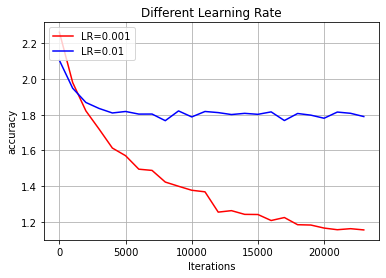

In [46]:
# To do
# Plot the training loss curve
plt.plot(Iterations,loss_list,'r')
plt.plot(Iterations,loss_list_larger_lr,'b')
plt.grid()
plt.title('Different Learning Rate')
plt.ylabel('accuracy')
plt.xlabel('Iterations')
plt.legend(['LR=0.001', 'LR=0.01'], loc='upper left')
plt.show()